# 使用预训练的 CNN

分成 2 步：

 1. 特征提取
 
 2. 微调模型


<img src='imgs/预训练模型对比.jpg' width='300' height='200' align='left'/>


为什么仅复用卷积基而不用密集连接分类器？卷积基更具有通用性，而且密集连接分类器不包含了位置信息了（转换成了向量了已经）。

In [1]:
from keras.applications import VGG16

# weights: 模型初始化的权重检查点
# include_top: 是否包含分类器，自带的有1000个类别，我们只有2个类别，不需要他的
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 317s 5us/step








In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

导入了预训练模型后，需要增加最后的密集连接分类器。有2种方法：

 1. 快速特征提取：在数据集上提前运行卷积基，输出结果序列化存储，后续直接创建新的线性分类器模型进行分类即可。
 
 2. 使用数据增强的特征提取：在现有模型之上增加一些 Dense 层，**端对端**的运行整个模型。
 
####  优缺点

|方法|优点|缺点|
|--|--|--|
|快速特征提取|输入仅需要运行一次，代价低|不允许进行数据增强|
|使用数据增强的特征提取|可使用数据增强，端对端|运行代价高|

##### 1. 快速特征提取

 1.1 提取出特征

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/haoxingxiao/academic/data/dogs-vs-cats/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i + 1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_lables = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


 1.2 实现自己的线性分类器

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30, 
                    batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6029 - acc: 0.6715 - val_loss: 0.4470 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4389 - acc: 0.8000 - val_loss: 0.3735 - val_acc: 0.8550
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3661 - acc: 0.8405 - val_loss: 0.3248 - val_acc: 0.8820
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3288 - acc: 0.8620 - val_loss: 0.3070 - val_acc: 0.8750
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2898 - 

看看 loss 和 accuracy：

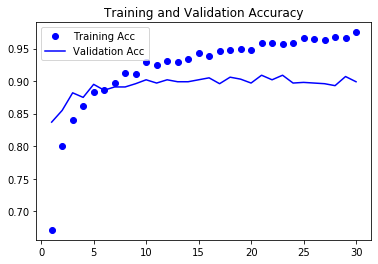

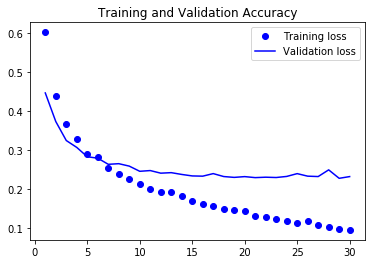

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

精确度达到了90%。比之前效果好很多。但是一开始就开始过拟合。
**使用数据增强对小数据集的过拟合非常重要。**

#### 2. 端对端

**警告：该方法只能在 GPU 上运行**

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


需要先冻结卷积基：

In [11]:
print('before freeze:', len(model.trainable_weights))
conv_base.trainable = False
print('after freeze:', len(model.trainable_weights))

before freeze: 30
after freeze: 4


冻结之后，只有Dense层的权重才会被训练。

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 68/100 [===================>..........] - ETA: 1:41 - loss: 0.5303 - acc: 0.7257